In [ ]:
!pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install numpy accelerate smalldiffusion tqdm diffusers transformers xformers

Looking in links: https://download.pytorch.org/whl/torch_stable.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 65.9 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import torchvision.transforms.v2.functional as TF
from accelerate import Accelerator
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from diffusers.utils.import_utils import is_xformers_available
from transformers import CLIPTextModel, CLIPTokenizer
from torch import nn
from torchvision.utils import save_image, make_grid
from smalldiffusion import ModelMixin, ScheduleLDM
from collections import namedtuple
from itertools import pairwise
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Introduction
In this exercise you will implement a custom sampler for a pretrained text-to-image diffusion model (Stable Diffusion 2.1). The goal is to modify classifier-free guidance during the sampling process to:

  1. Generate a series of images that interpolates between two different text prompts
  2. Generate visual illusions -- images that match different text prompts when viewed from different orientations

Stable Diffusion is a [latent diffusion model](https://arxiv.org/abs/2112.10752), where the diffusion process (with a 2D-Unet denoiser model) occurs in a (4x64x64)-dimensional latent space, guided by a text embedding from a pretrained [CLIP model](https://arxiv.org/abs/2103.00020) and tokenizer. The diffusion output in latent-space is decoded into a (3x512x512)-dimeisional pixel-space image with a pretrained variational autoencoder (VAE).

First we define a wrapper class for all of these models, which will handle the text encoding and VAE decoding after the diffusion process. We also load the model from a checkpoint.

In [ ]:
def alpha_bar(sigma):
    return 1/(sigma**2+1)

def show_tensor(x):
    display(TF.to_pil_image(x))

class ModelLatentDiffusion(nn.Module, ModelMixin):
    def __init__(self, model_key, accelerator=None):
        super().__init__()
        self.accelerator = accelerator or Accelerator()
        self.vae = AutoencoderKL.from_pretrained(model_key, subfolder="vae")
        self.tokenizer = CLIPTokenizer.from_pretrained(model_key, subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained(model_key, subfolder="text_encoder")
        self.unet = UNet2DConditionModel.from_pretrained(model_key, subfolder="unet")
        self.scheduler = DDIMScheduler.from_pretrained(model_key, subfolder="scheduler")
        self.input_dims = (self.unet.config.in_channels, self.unet.sample_size, self.unet.sample_size,)
        self.text_condition = None
        self.text_guidance_scale = None
        if is_xformers_available():
            self.unet.enable_xformers_memory_efficient_attention()
        self.to(self.accelerator.device)

    def tokenize(self, prompt):
        return self.tokenizer(
            prompt, padding='max_length', max_length=self.tokenizer.model_max_length,
            truncation=True, return_tensors='pt'
        ).input_ids.to(self.accelerator.device)

    def embed_prompt(self, prompt):
        with torch.no_grad():
            return self.text_encoder(self.tokenize(prompt))[0]

    @torch.no_grad()
    def decode_latents(self, latents):
        decoded = self.vae.decode(latents / 0.18215).sample
        normalized = (decoded.squeeze()+1)/2 # from [-1,1] to [0, 1]
        return normalized.clamp(0,1)

    def sigma_to_t(self, sigma):
        idx = torch.searchsorted(reversed(self.scheduler.alphas_cumprod.to(sigma)), alpha_bar(sigma))
        return self.scheduler.config.num_train_timesteps - 1 - idx

    def forward(self, x, sigma, cond=None):
        z = alpha_bar(sigma).sqrt() * x
        return self.unet(z, self.sigma_to_t(sigma), encoder_hidden_states=cond).sample

model = ModelLatentDiffusion('stabilityai/stable-diffusion-2-1-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

# Sampling with classifier-free guidance

Next, we provide a starter sampler code that implements classifier-free guidance. Given $e_0$ (embedding of the empty text prompt, or a negative prompt) and $e_1$ (embedding of the target text prompt) and a guidance scale $\gamma$, classifier-free guidance is implemented as:

$$\bar{\epsilon}_t = (1-\gamma) \epsilon(x_t, \sigma_t, e_0) + \gamma \epsilon(x_t, \sigma_t, e_1)$$

20it [00:10,  1.87it/s]


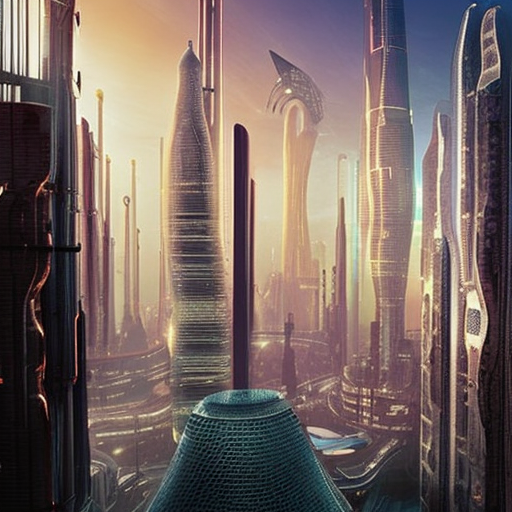

In [ ]:
def sample_cfg(model,
               prompt     = 'An astronaut riding a horse',
               neg_prompt = '',
               cfg_scale  = 7.5,
               N          = 50,
               gam        = 1.,
               mu         = 0.,
               seed       = 0,):
    model.eval()
    torch.manual_seed(seed)

    schedule = ScheduleLDM(1000)
    accelerator = Accelerator()

    # Embed text prompt and negative prompt
    embed, neg_embed = map(model.embed_prompt, (prompt, neg_prompt))

    # Create sampling noise schedule
    sigmas = schedule.sample_sigmas(N)

    # Generate
    xt = model.rand_input(1).to(accelerator.device) * sigmas[0]
    eps = None

    for i, (sig, sig_prev) in enumerate(tqdm(pairwise(sigmas))):
        # Model is evaluated on xt twice, conditioned on `prompt` and `neg_prompt` respectively
        with torch.no_grad():
            eps_pred = model.predict_eps(xt, sig.to(xt), embed)
            eps_pred_neg = model.predict_eps(xt, sig.to(xt), neg_embed)

        # Do classifier-free guidance
        eps_prev, eps = eps, (1-cfg_scale) * eps_pred_neg + cfg_scale * eps_pred

        # The rest of sampling, adding noise if mu > 0, acceleration if gam > 1.
        eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
        eta = (sig_prev**2 - sig_p**2).sqrt()
        xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
    return model.decode_latents(xt)

img = sample_cfg(model,
    prompt = 'A photograph of a futuristic city',
    neg_prompt = 'low resolution',
    cfg_scale  = 7,
    gam=1.5, mu=0., N=20, seed=0,
)
show_tensor(img)

# Question 1 (3 points): Interpolation

We can modify classifier-free guidance to interpolate between two different text prompts $e_1$ and $e_2$. This is done by combining the guidance terms and varying the guidance scales $\gamma_1$ and $\gamma_2$:


$$\bar{\epsilon}_t = (1-\gamma_1-\gamma_2) \epsilon(x_t, \sigma_t, e_0) + \gamma_1 \epsilon(x_t, \sigma_t, e_1) + \gamma_2 \epsilon(x_t, \sigma_t, e_2)$$

Implement a version of `sample_cfg` that takes in multiple prompts and guidance scales and performs classifier-free guidance using the different prompts. Code to call this sampler is provided below. Feel free to play around with the default parameters after you get the sampler working.

In [ ]:
def sample_multi_prompt(model,
                        prompts    = ['An astronaut riding a horse',
                                      'low resolution, blurry image, bad composition'],
                        cfg_scales = [7.5, -7.5],
                        N          = 50,
                        gam        = 1.,
                        mu         = 0.,
                        seed       = 0,):
    # Sans
    # assert sum(cfg_scales) == 1 # <--- apparently not? ^
    assert len(cfg_scales) == len(prompts)
    cfg_scales = torch.Tensor(cfg_scales).squeeze() # (len,)

    # Copy the begginning code of the function above
    model.eval()
    torch.manual_seed(seed)

    schedule = ScheduleLDM(1000)
    accelerator = Accelerator()

    # Embed all the prompts (analogous to above)
    embedded_prompts = torch.stack(list(map(model.embed_prompt, prompts)))
    # print("embedded_prompts.shape", embedded_prompts.shape) # DEBUG

    # Create sampling noise schedule
    sigmas = schedule.sample_sigmas(N)

    # Generate
    xt = model.rand_input(1).to(accelerator.device) * sigmas[0]
    eps = None

    for i, (sig, sig_prev) in enumerate(tqdm(pairwise(sigmas))):
        # Model is evaluated on xt as many times as necessary, conditioned for each prompt in `prompts` respectively
        # NOTE: this is done this way because we assume we won't do so many prompts at once that we exhaust memory
        with torch.no_grad():
          preds: torch.Tensor = torch.stack([model.predict_eps(xt, sig.to(xt), embed) for embed in embedded_prompts], dim=0)
          # print("preds.shape", preds.shape) # DEBUG

        # Do classifier-free guidance
        if len(cfg_scales.shape) != len(preds.shape):
          assert cfg_scales.shape == (preds.shape[0], )
          cfg_scales = cfg_scales.reshape(tuple([preds.shape[0]] + [1]*(len(preds.shape)-1)))
        assert len(cfg_scales.shape) == len(preds.shape)
        assert cfg_scales.shape[0] == preds.shape[0]
        assert all(cfg_scales.shape[i] == 1 for i in range(1, len(cfg_scales.shape)))
        eps_prev, eps = eps, (preds * cfg_scales.to(preds)).sum(axis=0)

        # The rest of sampling, adding noise if mu > 0, acceleration if gam > 1.
        eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps # <--- same as before using current and past interpolation
        sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu) <--- same as before
        eta = (sig_prev**2 - sig_p**2).sqrt() # <--- same as before
        xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt) # <--- same as before
    return model.decode_latents(xt)

20it [00:14,  1.34it/s]


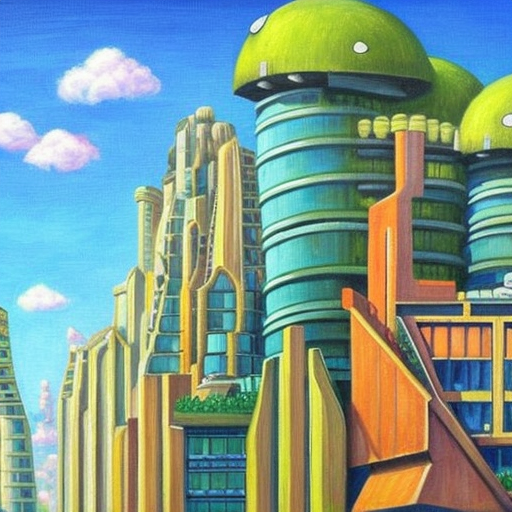

20it [00:15,  1.30it/s]


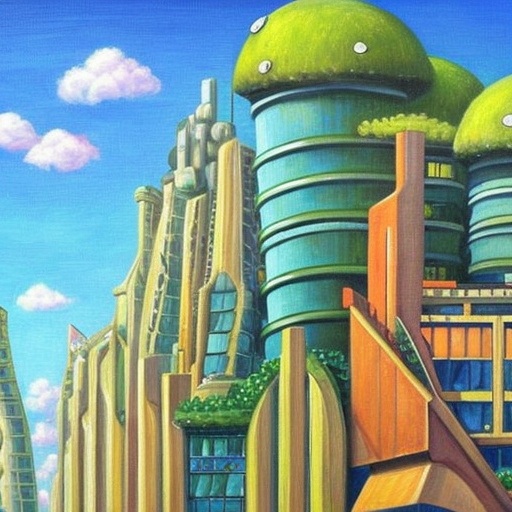

20it [00:15,  1.27it/s]


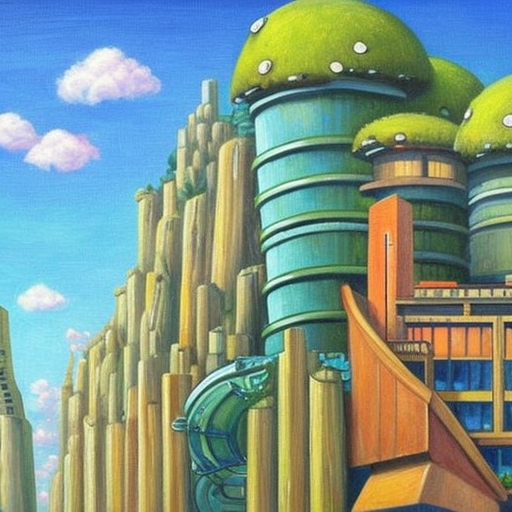

20it [00:15,  1.30it/s]


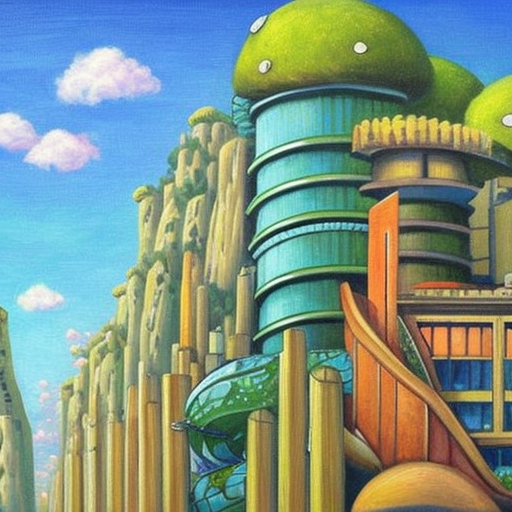

20it [00:15,  1.33it/s]


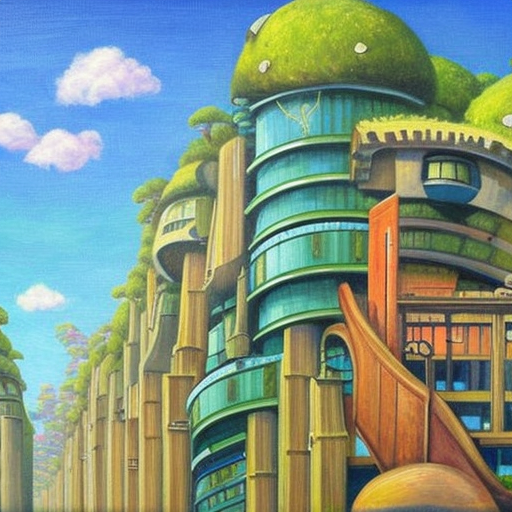

20it [00:15,  1.33it/s]


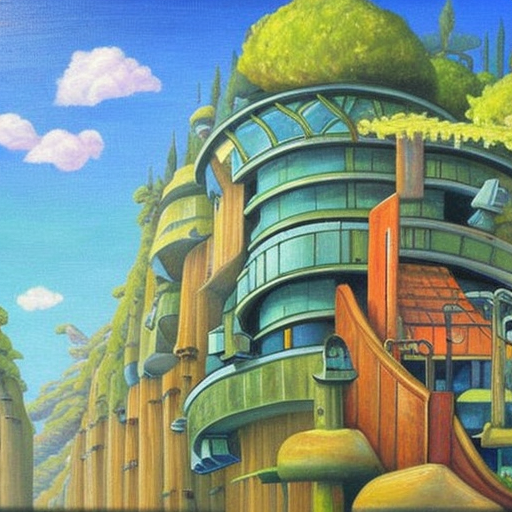

20it [00:15,  1.31it/s]


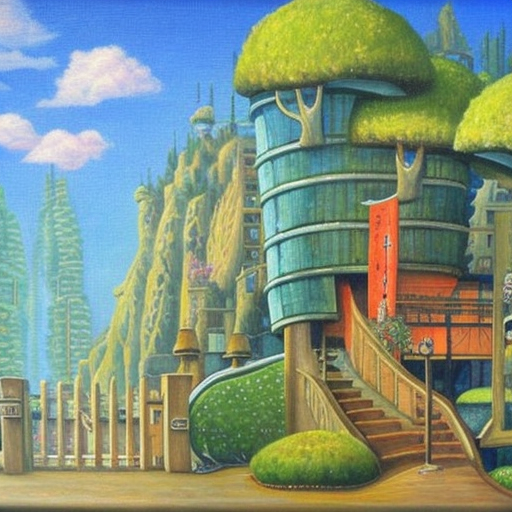

20it [00:15,  1.30it/s]


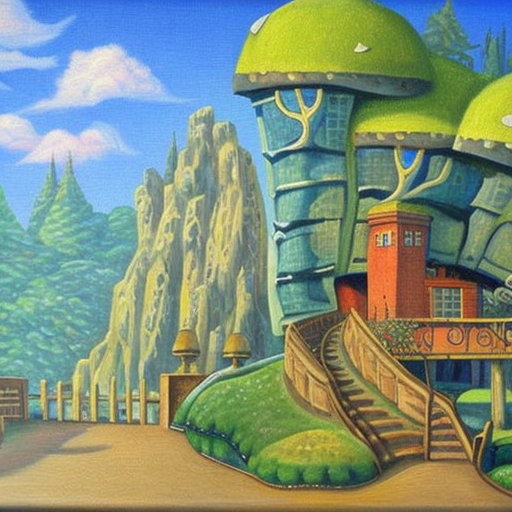

20it [00:15,  1.30it/s]


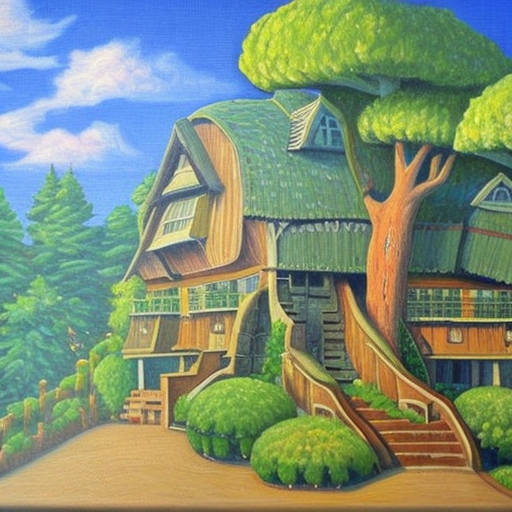

20it [00:15,  1.31it/s]


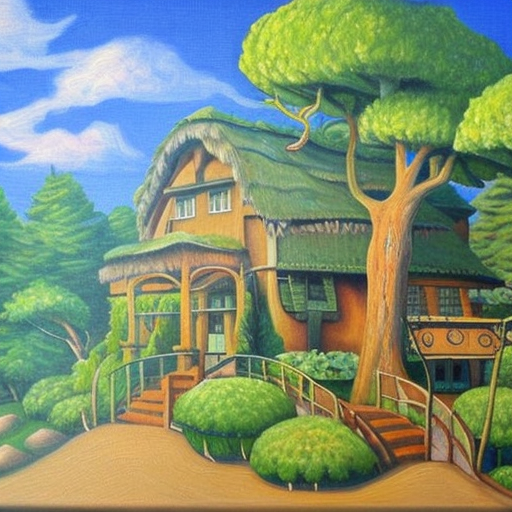

In [ ]:
# Modify the `sample_cfg` function above to take in multiple prompts and scales,
# enabling interpolation between two text prompts
for i, scale in enumerate(np.linspace(0, 4, 10)):
    img = sample_multi_prompt(
        model, gam=1.7, N=20, seed=7,
        prompts= ['low resolution, blurry image, bad composition',
                  'House in the woods, oil painting, ghibli inspired, high resolution',
                  'Building in a futuristic city, oil painting, ghibli inspired, high resolution',],
        cfg_scales =(-7, 2+scale, 6-scale),
    )
    show_tensor(img)

# Question 2 (3 points): Visual Illusions

We can also use classifier-free guidance to produce images that look like text prompt $e_1$ after applying transformation $t_1$ (e.g. a rotation), but also looks like text prompt $e_2$ after applying transformation $t_2$. This technique is further explored in the [visual anagrams paper](https://dangeng.github.io/visual_anagrams/); we will implement a basic version of it.


The main idea is to apply transform $t_1$ to the $x_t$ before applying classifier-free guidance conditioned on $e_1$, then applying its inverse $t_1^{-1}$ to the output. The same is done with $t_2$ and $e_2$.

$$
\begin{align*}
\bar{\epsilon}^1_t &= t_1^{-1}((1-\gamma) \epsilon(t_1(x_t), \sigma_t, e_0) + \gamma \epsilon(t_1(x_t), \sigma_t, e_1)) \\
\bar{\epsilon}^2_t &= t_2^{-1}((1-\gamma) \epsilon(t_2(x_t), \sigma_t, e_0) + \gamma \epsilon(t_2(x_t), \sigma_t, e_2))
\end{align*}
$$

The two outputs are then averaged:

$$\bar{\epsilon}_t = \frac{1}{2} (\bar{\epsilon}^1_t +\bar{\epsilon}^2_t)$$

Modify your sampler above to apply different transformations for different text prompts. Code to call this sampler to generate and display a visual illusion is provided below. Feel free to play around with the default parameters after you get the sampler working.

In [ ]:
import einops
def sample_transforms(model,
                      prompts  = ['An astronaut riding a horse',
                                  'low resolution, blurry image, bad composition'],
                      cfg_scales = [7.5, -7.5],
                      transforms = None,
                      N          = 50,
                      gam        = 1.,
                      mu         = 0.,
                      seed       = 0,):

    if transforms is None:
      raise ValueError("Please provide a transform")

    assert len(prompts) % len(transforms) == 0
    assert len(cfg_scales) == len(prompts)
    group_size = len(prompts) // len(transforms)

    ################ vvvv BELOW HERE SAME AS BEFORE vvvv ################
    # Sans
    assert sum(cfg_scales) == 1 # <--- apparently not? ^
    cfg_scales = torch.Tensor(cfg_scales).squeeze() # (len,)

    # Copy the begginning code of the function above
    model.eval()
    torch.manual_seed(seed)

    schedule = ScheduleLDM(1000)
    accelerator = Accelerator()

    # Embed all the prompts (analogous to above)
    embedded_prompts = torch.stack(list(map(model.embed_prompt, prompts)))
    # print("embedded_prompts.shape", embedded_prompts.shape) # DEBUG

    # Create sampling noise schedule
    sigmas = schedule.sample_sigmas(N)

    # Generate
    xt = model.rand_input(1).to(accelerator.device) * sigmas[0]
    eps = None
    ################ ^^^^ ABOVE HERE SAME AS BEFORE ^^^^ ################

    for i, (sig, sig_prev) in enumerate(tqdm(pairwise(sigmas))):
        # 1. Predict
        with torch.no_grad():
          # NOTE: assume INVARIANCE of sigmas/CFGs and EQUIVARIANCE of epsilon to make this totally kosher (note to self)
          # (also assume we won't exhaust mem. lmao)
          preds: torch.Tensor = torch.stack([model.predict_eps(transforms[i // group_size].fwd(xt), sig.to(xt), embed) for i, embed in enumerate(embedded_prompts)], dim=0)

        # 2. Do classifier-free guidance
        if len(cfg_scales.shape) != len(preds.shape):
          assert cfg_scales.shape == (preds.shape[0], )
          cfg_scales = cfg_scales.reshape(tuple([preds.shape[0]] + [1]*(len(preds.shape)-1)))
        assert len(cfg_scales.shape) == len(preds.shape)
        assert cfg_scales.shape[0] == preds.shape[0]
        assert all(cfg_scales.shape[i] == 1 for i in range(1, len(cfg_scales.shape)))

        # 3. Scale and group, reduce within groups (one group per transform.)
        eps_unflat_tensor = (preds * cfg_scales.to(preds))
        eps_reshaped = einops.rearrange(
            eps_unflat_tensor,
            '(n_groups group_size) ... -> n_groups group_size ...',
            n_groups=len(transforms),
            group_size=group_size
        )
        eps_reduced = eps_reshaped.sum(dim=1)
        assert eps_reduced.shape[0] == len(transforms)

        # 4. Invert each transformation to canonical form to average epsilons
        eps_inverted = torch.stack([tf.inv(e) for tf, e in zip(transforms, eps_reduced)], dim=0)
        assert eps_inverted.shape[0] == len(transforms)
        # NOTE: https://piazza.com/class/m5b9cuy61u412k/post/12 so we SUM since the cfg_scales already take the averaging into account (all sums to one!)
        eps_prev, eps = eps, eps_inverted.sum(dim=0)

        ################ vvvv SAME BELOW AS BEFORE vvvv ################
        # 4. The rest of sampling, adding noise if mu > 0, acceleration if gam > 1.
        assert i == 0 or eps.shape == eps_prev.shape
        eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps # <--- same as before using current and past interpolation
        # print("EPS AV SHAPE", eps_av.shape, "XT SHAPE", xt.shape) # DEBUG
        sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu) <--- same as before
        eta = (sig_prev**2 - sig_p**2).sqrt() # <--- same as before
        xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt) # <--- same as before
        ################ ^^^^ SAME AS BEFORE ^^^^ ################
    return model.decode_latents(xt)

50it [00:51,  1.04s/it]


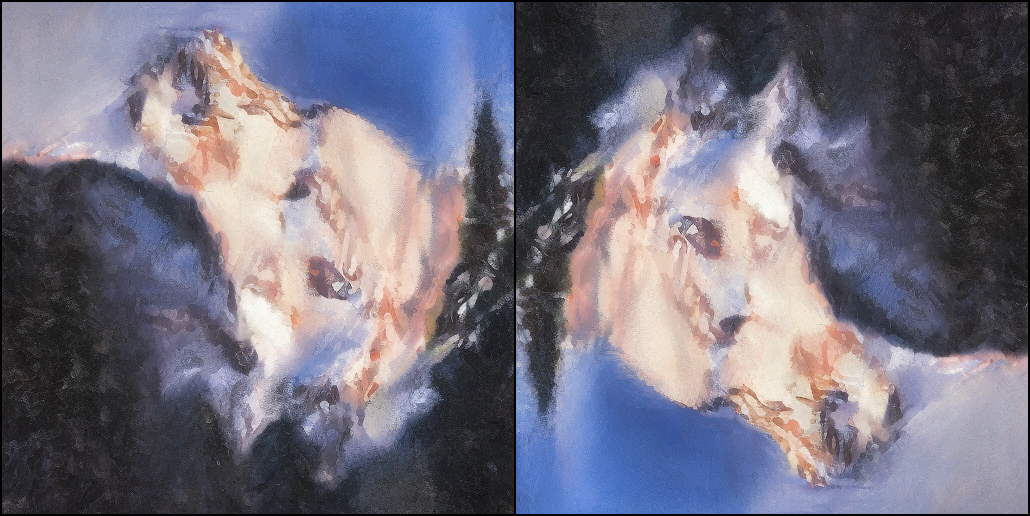

In [ ]:
# Define transforms used for illusions
Transform = namedtuple('Transform', ['fwd', 'inv'])
id_t = Transform(lambda x:x, lambda x:x)
r = lambda r: lambda x: TF.rotate(x, r)
rot_180 = Transform(r(180), r(-180))

transforms = (id_t, rot_180) # NOTE: modified to make more sense in the way that we pass this in

# Modify the `sample_cfg` function above to take in multiple transforms and
# apply them during classifer-free guidance
img = sample_transforms(
    model, gam=1.2, mu=0.5, N=50, seed=0,
    # NOTE: re-arranged into "towards-away-from" (per-transformation) groups
    prompts=('', # Unconditional null-text prompts
            'A painting of a snowy mountain',
             '',
             'A painting of a horse'),
    transforms = transforms,
    # NOTE: sum to 1 -> averageging is done ASSUMING INVARIANCE + EQUIVARIANCE (seems to be assumed by formula above)
    cfg_scales = (-3, 3.5, -3, 3.5),
)
imgs_t = [t.fwd(img) for t in transforms] # <--- 2 transforms now
show_tensor(make_grid(torch.stack(imgs_t)))